# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, GaussianNoise, GaussianDropout, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn

import time
import math
import os

# Parameters

In [3]:
num_calsses = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
input_size = (32,32,3)

# Import data

In [4]:
(learning_images, learning_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# shaffle learning images
np.random.seed(1234321)
permutation = np.random.choice(range(learning_images.shape[0]), learning_images.shape[0], False)
learning_images = learning_images[permutation]
learning_labels = learning_labels[permutation]

# select train and validation (20 percent)
train_images = learning_images[0:40960]
train_labels = learning_labels[0:40960]

val_images = learning_images[40960:]
val_labels = learning_labels[40960:]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_images)))
print("- Validtion-set:\t{}".format(len(val_images)))
print("- Test-set:\t\t{}".format(len(test_images)))

Size of:
- Training-set:		40960
- Validtion-set:	9040
- Test-set:		10000


In [6]:
# one hot
train_labels_one_hot = tf.one_hot(train_labels[:, 0].T, num_calsses)
val_labels_one_hot = tf.one_hot(val_labels[:, 0].T, num_calsses)
test_labels_one_hot = tf.one_hot(test_labels[:, 0].T, num_calsses)

In [7]:
# normalize
train_images_normalized = (train_images- np.mean(train_images, axis=0)) / (1e-3 + np.sqrt(np.var(train_images, axis=0)))
val_images_normalized = (val_images- np.mean(val_images, axis=0)) / (1e-3 + np.sqrt(np.var(val_images, axis=0)))
test_images_normalized = (test_images- np.mean(test_images, axis=0)) / (1e-3 + np.sqrt(np.var(test_images, axis=0)))

## Augment sample image

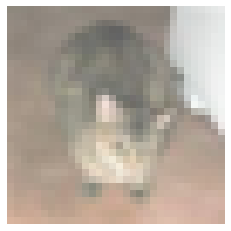

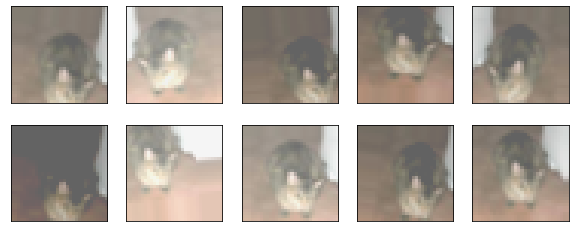

In [8]:
image = train_images[5]
fig = plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')

image = image[np.newaxis, ...]
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.25, height_shift_range=0.25, shear_range=0.25, zoom_range=0.1, channel_shift_range=0.2, horizontal_flip=True)
aug_iter = image_data_generator.flow(image, batch_size=1)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    temp_image = next(aug_iter)[0]
    plt.imshow(temp_image)
plt.show()

## Unbalanced data set

In [9]:
selection_indexes = []
cat_counter = 0
dog_counter = 0

for i in range(len(train_labels)) :
  if(class_names[train_labels[i][0]] == 'cat'):
    cat_counter += 1
    if(cat_counter%10==0):
      selection_indexes.append(i)

  elif(class_names[train_labels[i][0]] == 'dog'):
    dog_counter += 1
    if(dog_counter%10==0):
      selection_indexes.append(i)

  else:
    selection_indexes.append(i)

unbalanced_train_images_dataset = train_images[selection_indexes]
unbalanced_train_images_labels = train_labels[selection_indexes]

# one hot
unbalanced_train_images_labels_one_hot = tf.one_hot(unbalanced_train_images_labels[:, 0].T, num_calsses)

# normalize
unbalanced_train_images_dataset_normalized = (unbalanced_train_images_dataset- np.mean(unbalanced_train_images_dataset, axis=0)) / (1e-3 + np.sqrt(np.var(unbalanced_train_images_dataset, axis=0)))


In [10]:
model = Sequential()    # actually tf.keras.models.Sequential

reg = tf.keras.regularizers.L1L2(
    l1=0.00001, l2=0.0001
)

model = Sequential()
model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())
model.add(GaussianNoise(0.1))
model.add(Dense(1024, activation = 'relu', kernel_regularizer=reg))   # Hidden 32*32*3 -> 1024
model.add(GaussianDropout(0.4))
model.add(Dense(256, activation = 'relu', kernel_regularizer=reg))    # Hidden 1024 -> 256
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax', kernel_regularizer=reg))  # OUTPUT 256 -> 10

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics='accuracy')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       9728      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                      

In [12]:
# Callbacks definition
def scheduler(epoch, lr):
   if epoch < 3:
     return lr
   else:
     return lr / 1.01

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [13]:
history = model.fit(
    x=unbalanced_train_images_dataset_normalized, y=unbalanced_train_images_labels_one_hot, batch_size=32, epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

model.save('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_unbalanced')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_unbalanced/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1051/1051 [==============================] - 29s 19ms/step - loss: 2.0805 - accuracy: 0.4348 - val_loss: 2.1604 - val_accuracy: 0.4509 - lr: 0.0100
Epoch 2/40
1051/1051 [==============================] - 18s 17ms/step - loss: 1.7168 - accuracy: 0.5714 - val_loss: 1.8963 - val_accuracy: 0.5194 - lr: 0.0100
Epoch 3/40
1051/1051 [==============================] - 19s 18ms/step - loss: 1.5510 - accuracy: 0.6341 - val_loss: 1.8561 - val_accuracy: 0.5520 - lr: 0.0100
Epoch 4/40
1051/1051 [==============================] - 19s 18ms/step - loss: 1.4445 - accuracy: 0.6752 - val_loss: 1.7684 - val_accuracy: 0.5821 - lr: 0.0099
Epoch 5/40
1051/1051 [==============================] - 19s 18ms/step - loss: 1.3526 - accuracy: 0.7043 - val_loss: 1.7351 - val_accuracy: 0.5976 - lr: 0.0098
Epoch 6/40
1051/1051 [==============================] - 19s 18ms/step - loss: 1.2824 - accuracy: 0.7281 - val_loss: 1.6766 - val_accuracy: 0.6146 - lr: 0.0097
Epoch 7/40
1051/1051 [========================

FileNotFoundError: ignored

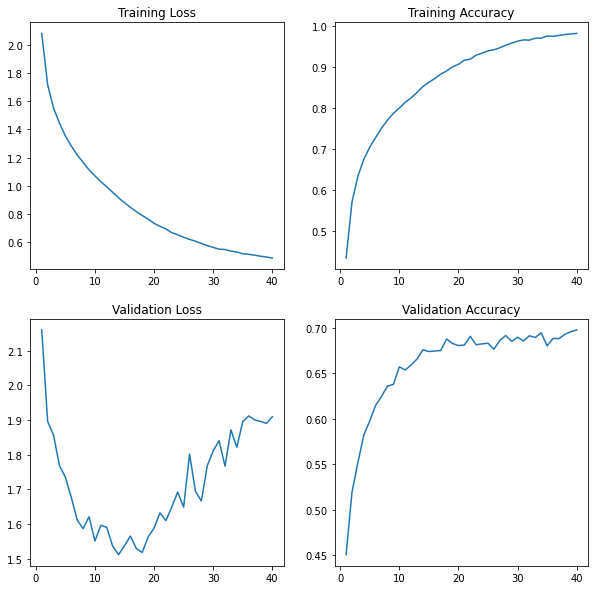

In [20]:
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_unbalanced/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

313/313 [==============================] - 4s 12ms/step - loss: 1.9237 - accuracy: 0.6906
Test Loss =  1.923722505569458
Test Accuracy =  0.6905999779701233


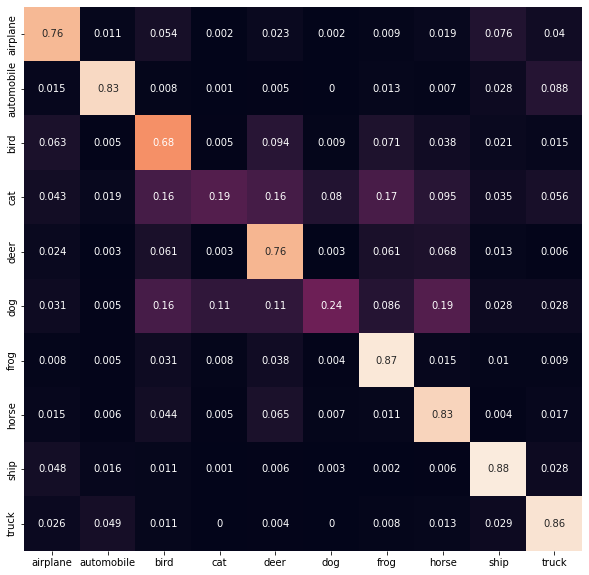

In [21]:
# Confusion matrix
model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_unbalanced')
[test_loss, test_accuracy] = model.evaluate(test_images_normalized, test_labels_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(test_images_normalized)
confusion_matrix = tf.math.confusion_matrix(test_labels, np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True, cbar=False)

## Augment unbalanced data set

In [22]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.25, height_shift_range=0.25, shear_range=0.25, zoom_range=0.1, channel_shift_range=0.2, horizontal_flip=True)

# Unbalance and again balance dataset

cat_counter = 0
cat_temp = train_images[0]
dog_counter = 0
dog_temp = train_images[0]

new_train_images = train_images
new_train_labels = train_labels

for i in range(len(train_labels)) :
  if(class_names[train_labels[i][0]] == 'cat'):
    cat_counter += 1
    if(cat_counter%10==1):
      cat_temp = train_images[i]
    else:
      image = cat_temp
      image = image[np.newaxis, ...]
      aug_iter = image_data_generator.flow(image, batch_size=1)
      new_train_images[i] = next(aug_iter)[0]

  if(class_names[train_labels[i][0]] == 'dog'):
    dog_counter += 1
    if(dog_counter%10==1):
      bird_temp = train_images[i]
    else:
      image = bird_temp
      image = image[np.newaxis, ...]
      aug_iter = image_data_generator.flow(image, batch_size=1)
      new_train_images[i] = next(aug_iter)[0]

# normalize
new_train_images_normalized = (new_train_images- np.mean(new_train_images, axis=0)) / (1e-3 + np.sqrt(np.var(new_train_images, axis=0)))


In [23]:
history = model.fit(
    x=new_train_images_normalized, y=train_labels_one_hot, batch_size=32, epochs=40, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images_normalized, val_labels_one_hot), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

model.save('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_augmented_unbalanced')

hist_df = pd.DataFrame(history.history)
with open('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_augmented_unbalanced/history.csv', mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/40
1280/1280 [==============================] - 28s 21ms/step - loss: 0.8126 - accuracy: 0.8565 - val_loss: 1.4585 - val_accuracy: 0.7129 - lr: 0.0069
Epoch 2/40
1280/1280 [==============================] - 22s 17ms/step - loss: 0.7247 - accuracy: 0.8812 - val_loss: 1.4506 - val_accuracy: 0.7208 - lr: 0.0069
Epoch 3/40
1280/1280 [==============================] - 21s 17ms/step - loss: 0.6835 - accuracy: 0.8954 - val_loss: 1.5227 - val_accuracy: 0.7153 - lr: 0.0069
Epoch 4/40
1280/1280 [==============================] - 22s 17ms/step - loss: 0.6608 - accuracy: 0.9023 - val_loss: 1.5599 - val_accuracy: 0.7176 - lr: 0.0069
Epoch 5/40
1280/1280 [==============================] - 21s 17ms/step - loss: 0.6406 - accuracy: 0.9122 - val_loss: 1.4950 - val_accuracy: 0.7218 - lr: 0.0068
Epoch 6/40
1280/1280 [==============================] - 22s 17ms/step - loss: 0.6191 - accuracy: 0.9186 - val_loss: 1.5381 - val_accuracy: 0.7179 - lr: 0.0067
Epoch 7/40
1280/1280 [========================

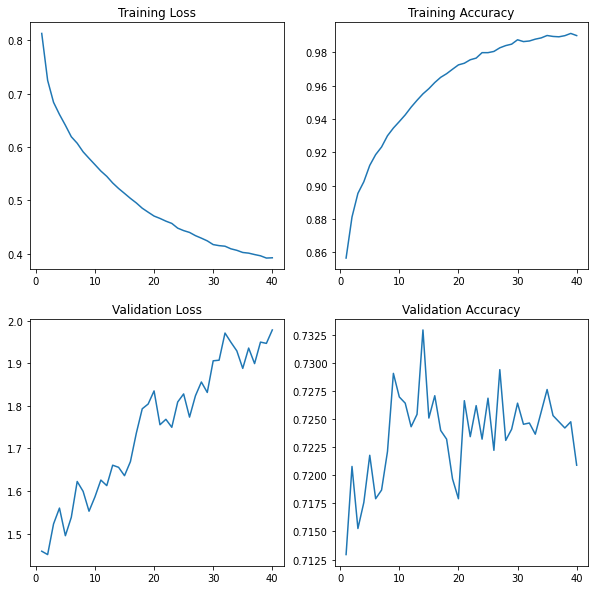

In [24]:
history = pd.read_csv('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_augmented_unbalanced/history.csv')
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Training Loss')
plt.plot(range(1, len(history['loss']) + 1), history['loss'])
ax = fig.add_subplot(2, 2, 2)
ax.set_title('Training Accuracy')
plt.plot(range(1, len(history['accuracy']) + 1), history['accuracy'])
ax = fig.add_subplot(2, 2, 3)
ax.set_title('Validation Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'])
ax = fig.add_subplot(2, 2, 4)
ax.set_title('Validation Accuracy')
plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'])

313/313 [==============================] - 3s 9ms/step - loss: 1.9332 - accuracy: 0.7247
Test Loss =  1.9331910610198975
Test Accuracy =  0.7246999740600586


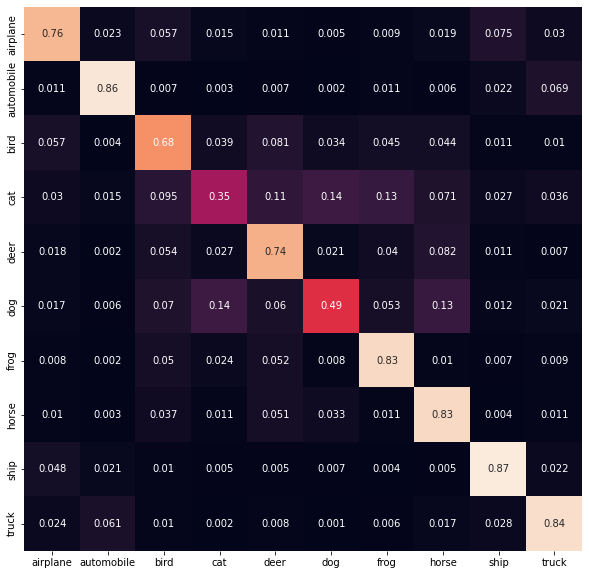

In [25]:
# Confusion matrix
model = tf.keras.models.load_model('./drive/MyDrive/DeepLearning_HW2/Data_Augmentation/models/cnn_augmented_unbalanced')
[test_loss, test_accuracy] = model.evaluate(test_images_normalized, test_labels_one_hot)
print('Test Loss = ', test_loss)
print('Test Accuracy = ', test_accuracy)
predicted_Y_test = model.predict(test_images_normalized)
confusion_matrix = tf.math.confusion_matrix(test_labels, np.argmax(predicted_Y_test, axis=-1), num_calsses).numpy()
confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1)
df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True, cbar=False)